In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'ray_tracing_synthesis')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import torch
torch.use_deterministic_algorithms(True)
import matplotlib.pyplot as plt
from model import build_net

from utils import remove_blind_region_psf0, remove_blind_region_psf7p5, remove_blind_region_minuspsf7p5,set_stateless_batchnorm

import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
import time
from time import sleep
from PIL import Image

from ray_tracing_synthesis import SoSToTimeShiftTransformer, image_to_sos_map

PARAM_SOS_BEAMFORMING = 1540
PARAM_SCALING_INPUT = 100000000
PARAM_SCALING_OUTPUT = 100
PARAM_BASE_OUTPUT = PARAM_SOS_BEAMFORMING
PARAM_NUMBER_OF_TRAINING_DATA = 1280000
PARAM_LEARNING_RATE = 0.0005
PARAM_WEIGHTDECAY = 0.3
EPOCH_NUM = 3
BATCH_SIZE = 32
GPU_BASE = 4
GPU_LIST_TO_PARALLEL = [GPU_BASE, 1,2,3] ### Specify the available GPU indices in your machine 
from worker_module import preparing_training_data  


data_parent_dir = (
    './untar_ImageNet_6_1/'
)

def eval_testingdata(model, test_data, test_label, criterion):
    outputs = (
        model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
        [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
        + PARAM_BASE_OUTPUT
    )
    loss = criterion(outputs, test_label.to(f"cuda:{GPU_BASE}", dtype=torch.float))
    print("RMSE in testing set is", torch.sqrt(loss.cpu()).detach().numpy())



import multiprocessing as mp
mp.set_start_method("spawn", force=True)

# Prepare test data
transformer = SoSToTimeShiftTransformer()
sos_from_ImageNet = []
time_lag_from_ImageNet = []
for i in range(PARAM_NUMBER_OF_TRAINING_DATA+1, PARAM_NUMBER_OF_TRAINING_DATA+201):
    image = Image.open(f"{data_parent_dir}grayscale_cropped_{i}.JPEG")
    sos_map = image_to_sos_map(image)
    time_lag_from_ImageNet.append([
        remove_blind_region_psf7p5(transformer.transform(sos_map, "7p5psf")),
        remove_blind_region_psf0(transformer.transform(sos_map, "0psf")),
        remove_blind_region_minuspsf7p5(transformer.transform(sos_map, "minus7p5psf")),
    ])
    sos_from_ImageNet.append(sos_map[:, 19:-19])

test_data = torch.tensor(np.array(time_lag_from_ImageNet))
test_label = torch.tensor(np.array(sos_from_ImageNet)).unsqueeze(1)
del sos_from_ImageNet, time_lag_from_ImageNet


Class initializing, device is cuda


In [2]:
def visualize_test_data():
    fig, axs = plt.subplots(2, 6, figsize=(16, 6))
    outputs_test = (
            model((test_data * PARAM_SCALING_INPUT).to(f"cuda:{GPU_BASE}", dtype=torch.float))
            [:, :, :, 19:-19] * PARAM_SCALING_OUTPUT
            + PARAM_BASE_OUTPUT
        ).cpu().detach().numpy()

    for i in range(2):
        for j in range(6):
            # Example: Plot a sine wave with a different phase in each subplot
            x = np.linspace(0, 2 * np.pi, 100)
            y = np.sin(x + (i * 4 + j))
            if i == 0:
                im = axs[i, j].imshow(test_label[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Ground Truth")
            if i == 1:
                im = axs[i, j].imshow(outputs_test[100+j,0],cmap = 'hot',vmin = 1400, vmax = 1600)
                axs[i, j].set_title(f"Reconstructed")
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            cbar = fig.colorbar(im, ax=axs[i, j])
            cbar.set_label("SoS [m/s]",fontsize = 13)

    plt.tight_layout()
    plt.show()

Elapsed time = 20.65330672264099
batch 1 / 40000
running_loss = 5048.780029296875
batch_loss = 4345.33984375
queue length = 4016
RMSE in testing set is 61.84554


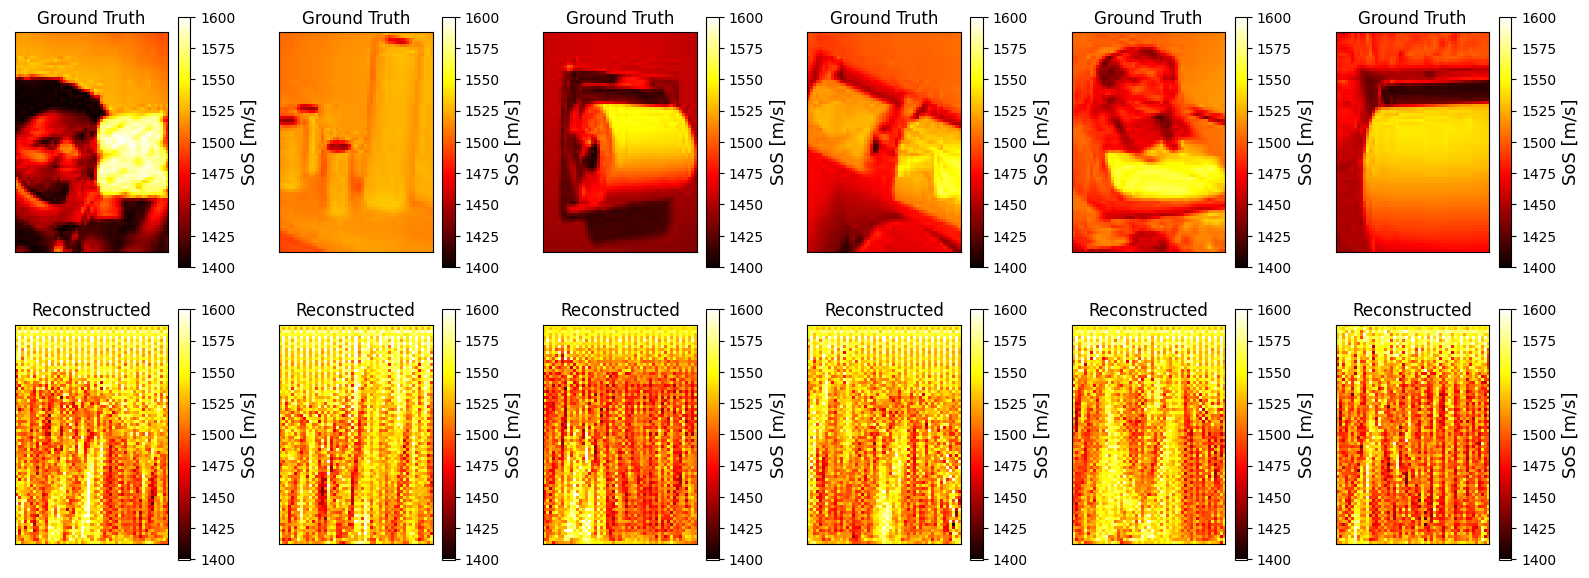

Elapsed time = 69.57502222061157
batch 1001 / 40000
running_loss = 1312.5896351218462
batch_loss = 907.0592651367188
queue length = 36
RMSE in testing set is 27.025324
Elapsed time = 77.23797702789307
batch 2001 / 40000
running_loss = 1106.2196225710325
batch_loss = 872.641845703125
queue length = 256
RMSE in testing set is 23.796627
Elapsed time = 78.53888869285583
batch 3001 / 40000
running_loss = 996.8831054565511
batch_loss = 756.9995727539062
queue length = 266
RMSE in testing set is 22.308687


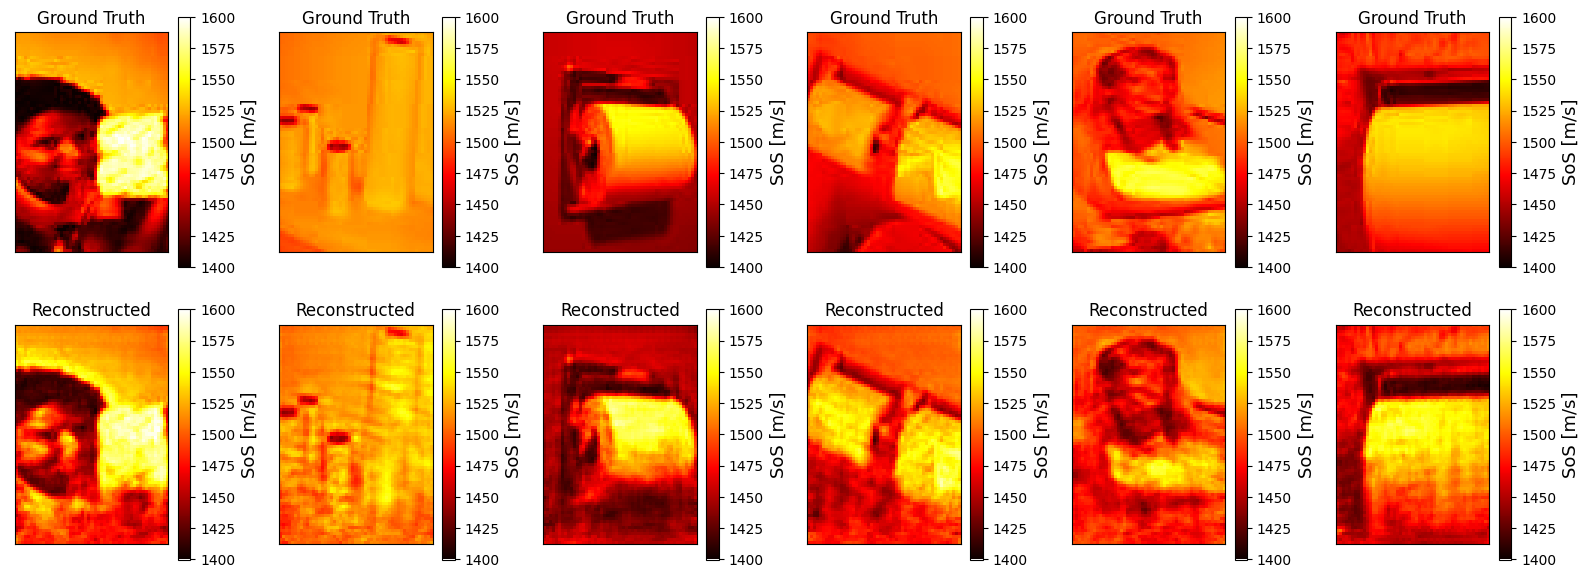

Elapsed time = 77.07080554962158
batch 4001 / 40000
running_loss = 923.8377745636459
batch_loss = 706.54541015625
queue length = 96
RMSE in testing set is 21.018154
Elapsed time = 80.25708246231079
batch 5001 / 40000
running_loss = 867.8989370621381
batch_loss = 648.06103515625
queue length = 376
RMSE in testing set is 20.937159
Elapsed time = 77.74830436706543
batch 6001 / 40000
running_loss = 823.5724165604059
batch_loss = 536.90234375
queue length = 236
RMSE in testing set is 19.865917


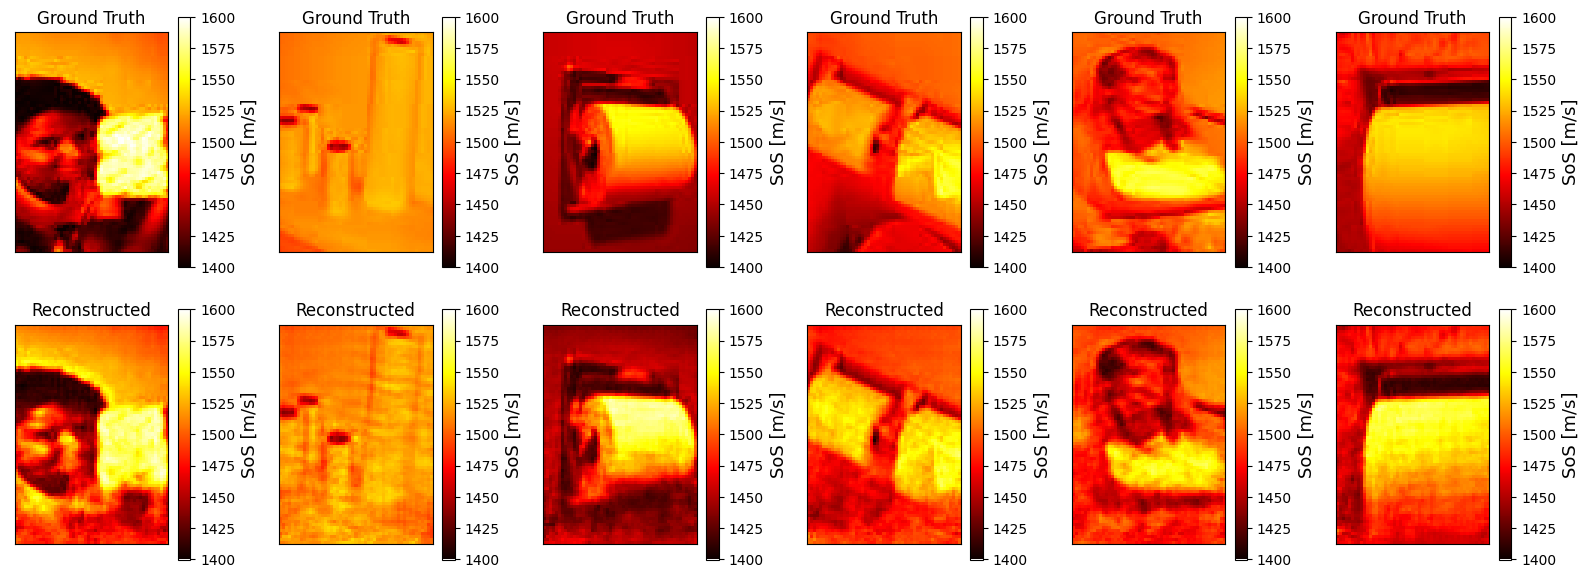

Elapsed time = 77.08616161346436
batch 7001 / 40000
running_loss = 786.8673000297557
batch_loss = 440.2784729003906
queue length = 66
RMSE in testing set is 18.89932
Elapsed time = 83.02963042259216
batch 8001 / 40000
running_loss = 757.136826446312
batch_loss = 473.8311462402344
queue length = 76
RMSE in testing set is 19.039335
Elapsed time = 84.70270133018494
batch 9001 / 40000
running_loss = 730.1479105276682
batch_loss = 556.9805297851562
queue length = 176
RMSE in testing set is 18.52007


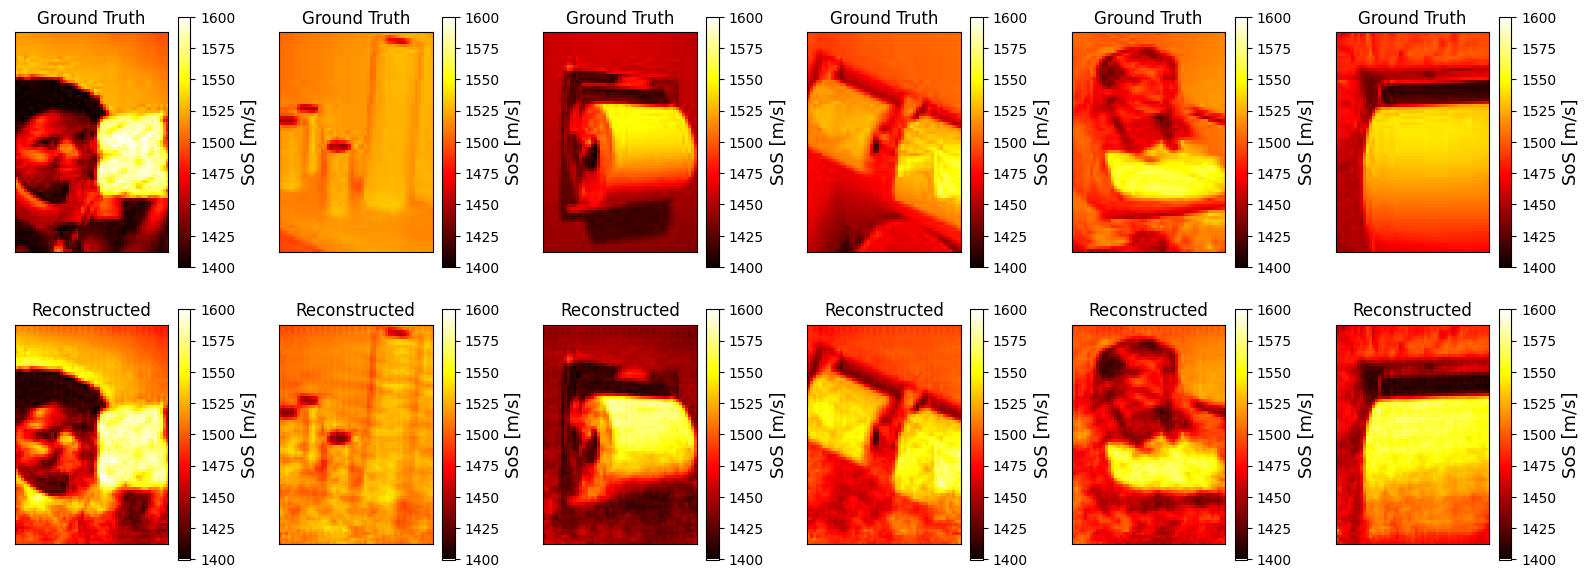

Elapsed time = 83.58700108528137
batch 10001 / 40000
running_loss = 706.922031026534
batch_loss = 453.0117492675781
queue length = 186
RMSE in testing set is 17.55087
Elapsed time = 79.93444609642029
batch 11001 / 40000
running_loss = 686.4428875591511
batch_loss = 524.1739501953125
queue length = 76
RMSE in testing set is 18.496855
Elapsed time = 87.2067174911499
batch 12001 / 40000
running_loss = 668.2752671155149
batch_loss = 396.36175537109375
queue length = 176
RMSE in testing set is 17.628359


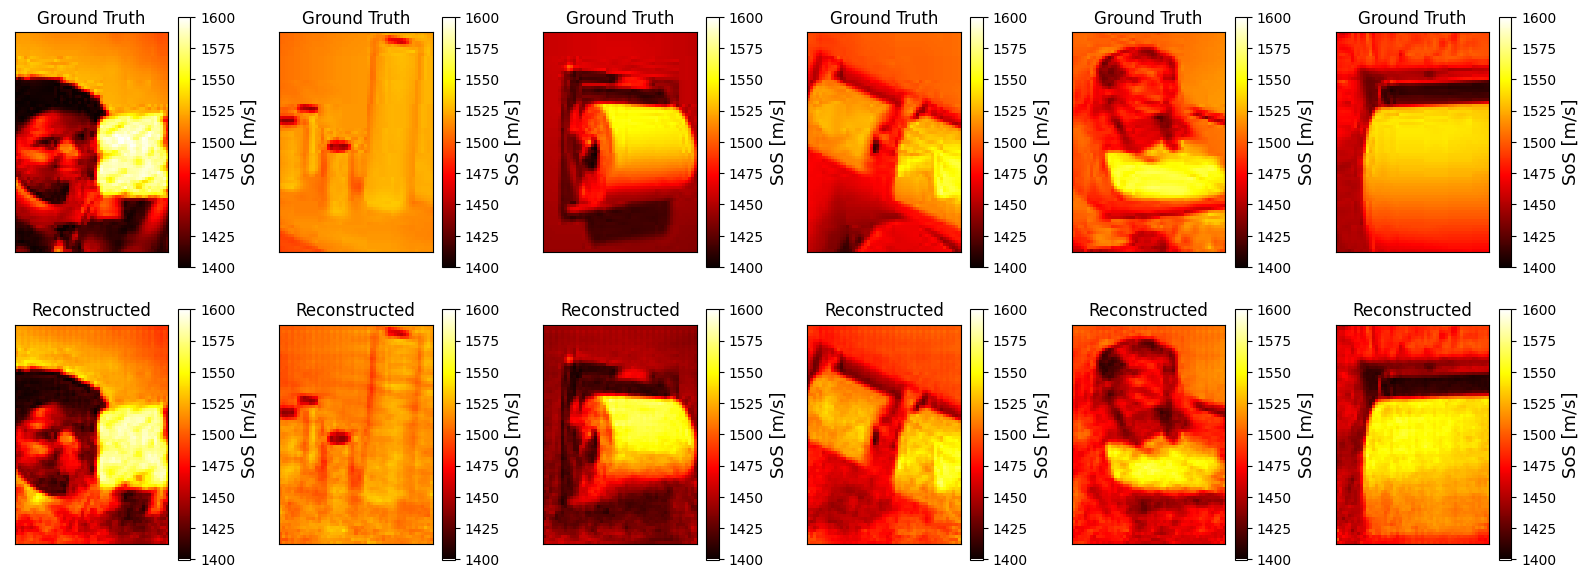

Elapsed time = 82.24970173835754
batch 13001 / 40000
running_loss = 651.7374035093421
batch_loss = 527.1690063476562
queue length = 36
RMSE in testing set is 16.853397
Elapsed time = 85.39511251449585
batch 14001 / 40000
running_loss = 636.5322668639238
batch_loss = 430.0265197753906
queue length = 376
RMSE in testing set is 17.293196
Elapsed time = 83.67310166358948
batch 15001 / 40000
running_loss = 622.85196253618
batch_loss = 487.8408508300781
queue length = 206
RMSE in testing set is 19.560951


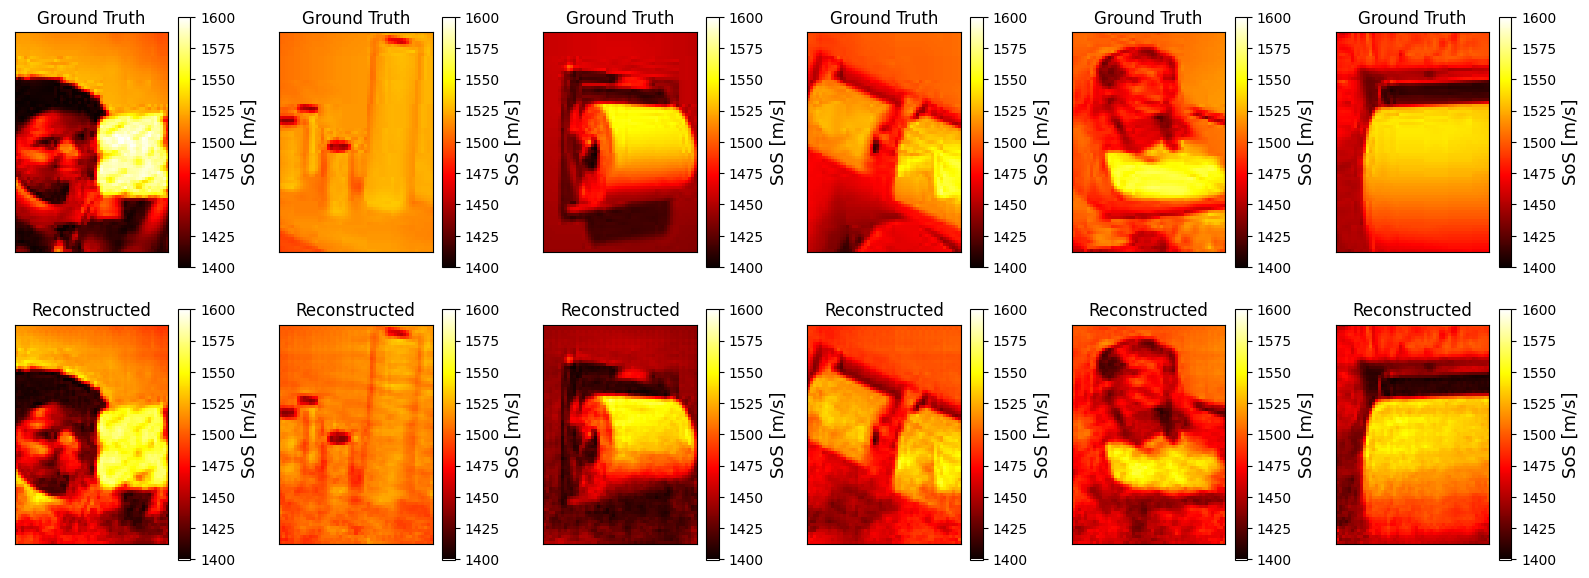

Elapsed time = 86.03051328659058
batch 16001 / 40000
running_loss = 610.348778140022
batch_loss = 395.17425537109375
queue length = 336
RMSE in testing set is 16.53985
Elapsed time = 85.33035278320312
batch 17001 / 40000
running_loss = 598.6954673746447
batch_loss = 382.37408447265625
queue length = 286
RMSE in testing set is 15.826966
Elapsed time = 85.74806642532349
batch 18001 / 40000
running_loss = 587.978985121377
batch_loss = 325.5223693847656
queue length = 446
RMSE in testing set is 15.716865


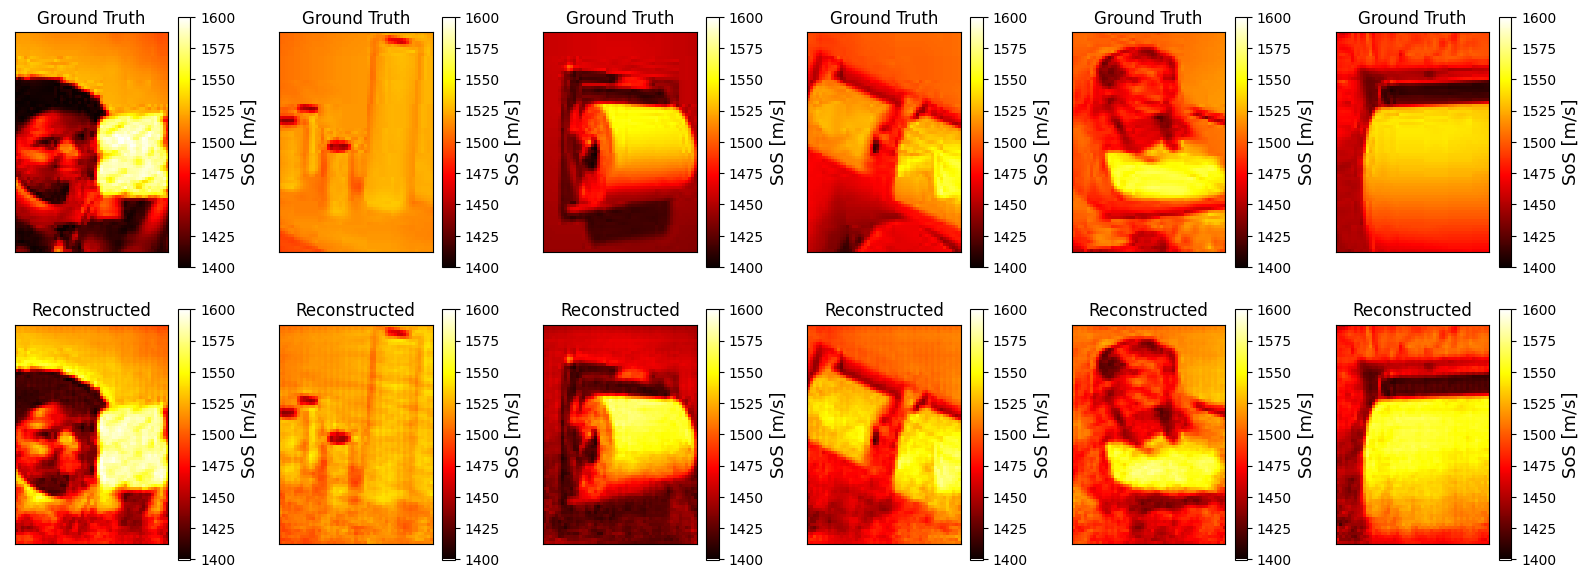

Elapsed time = 82.74484062194824
batch 19001 / 40000
running_loss = 578.2288321569434
batch_loss = 341.6504821777344
queue length = 126
RMSE in testing set is 15.380011
Elapsed time = 87.55991816520691
batch 20001 / 40000
running_loss = 568.9221731124312
batch_loss = 342.46234130859375
queue length = 196
RMSE in testing set is 15.341893
Elapsed time = 85.50005745887756
batch 21001 / 40000
running_loss = 560.3300742605347
batch_loss = 356.7798156738281
queue length = 26
RMSE in testing set is 16.058483


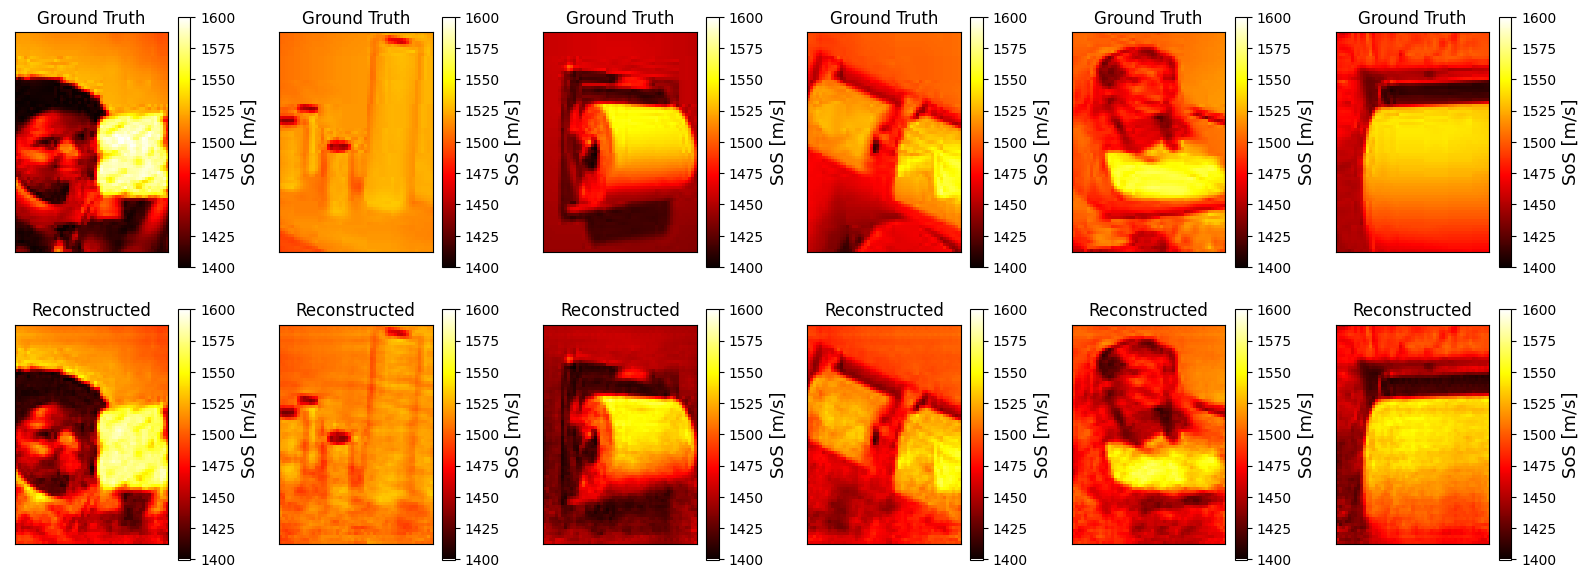

Elapsed time = 79.42169570922852
batch 22001 / 40000
running_loss = 552.2033139344899
batch_loss = 388.2134704589844
queue length = 216
RMSE in testing set is 14.862246
Elapsed time = 77.8065185546875
batch 23001 / 40000
running_loss = 544.3829632974606
batch_loss = 391.5344543457031
queue length = 256
RMSE in testing set is 14.972836
Elapsed time = 84.51667284965515
batch 24001 / 40000
running_loss = 537.1455992997542
batch_loss = 343.8038635253906
queue length = 116
RMSE in testing set is 14.862624


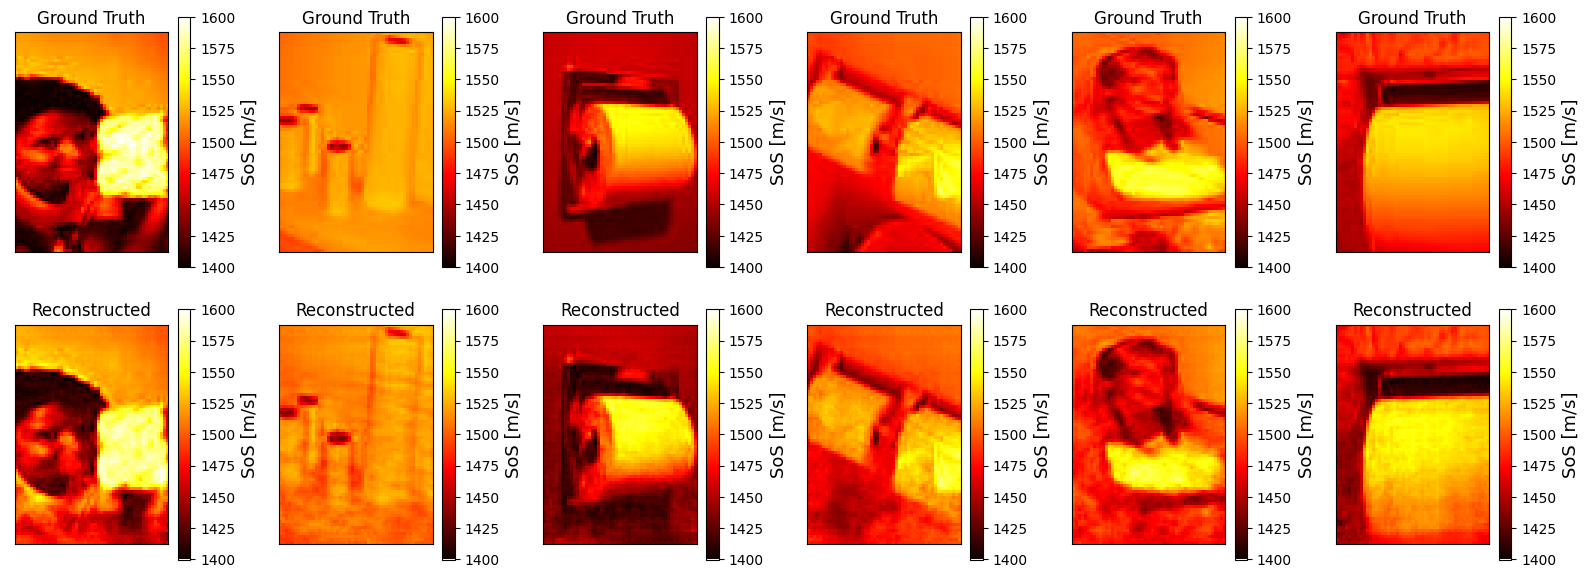

Elapsed time = 85.22462153434753
batch 25001 / 40000
running_loss = 530.3294630216204
batch_loss = 411.1434326171875
queue length = 36
RMSE in testing set is 15.042962
Elapsed time = 86.38622879981995
batch 26001 / 40000
running_loss = 524.0131078502525
batch_loss = 427.57110595703125
queue length = 316
RMSE in testing set is 15.259139
Elapsed time = 86.2099027633667
batch 27001 / 40000
running_loss = 518.0076144132055
batch_loss = 360.65631103515625
queue length = 356
RMSE in testing set is 14.416217


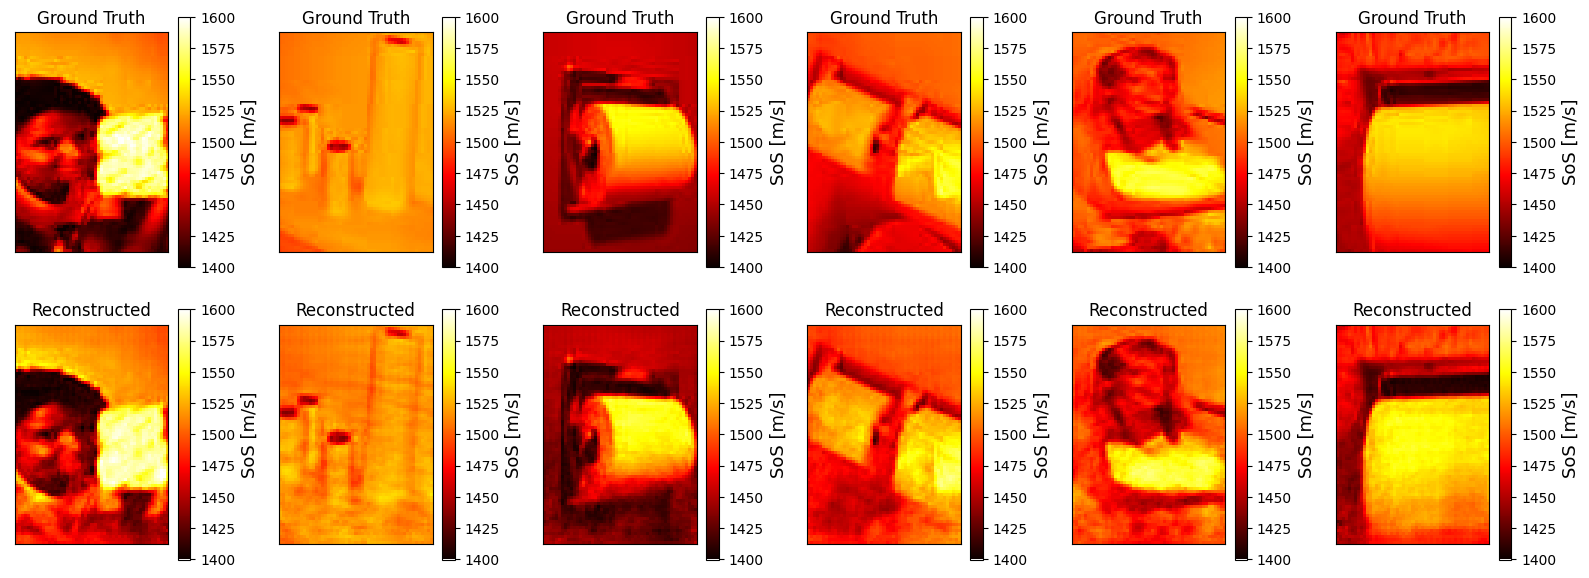

Elapsed time = 84.40773892402649
batch 28001 / 40000
running_loss = 512.3437055052796
batch_loss = 369.97711181640625
queue length = 126
RMSE in testing set is 15.3606415
Elapsed time = 83.1802704334259
batch 29001 / 40000
running_loss = 506.7340266758652
batch_loss = 401.41961669921875
queue length = 286
RMSE in testing set is 17.614101
Elapsed time = 88.1683337688446
batch 30001 / 40000
running_loss = 501.4725469265387
batch_loss = 310.2250671386719
queue length = 56
RMSE in testing set is 16.556194


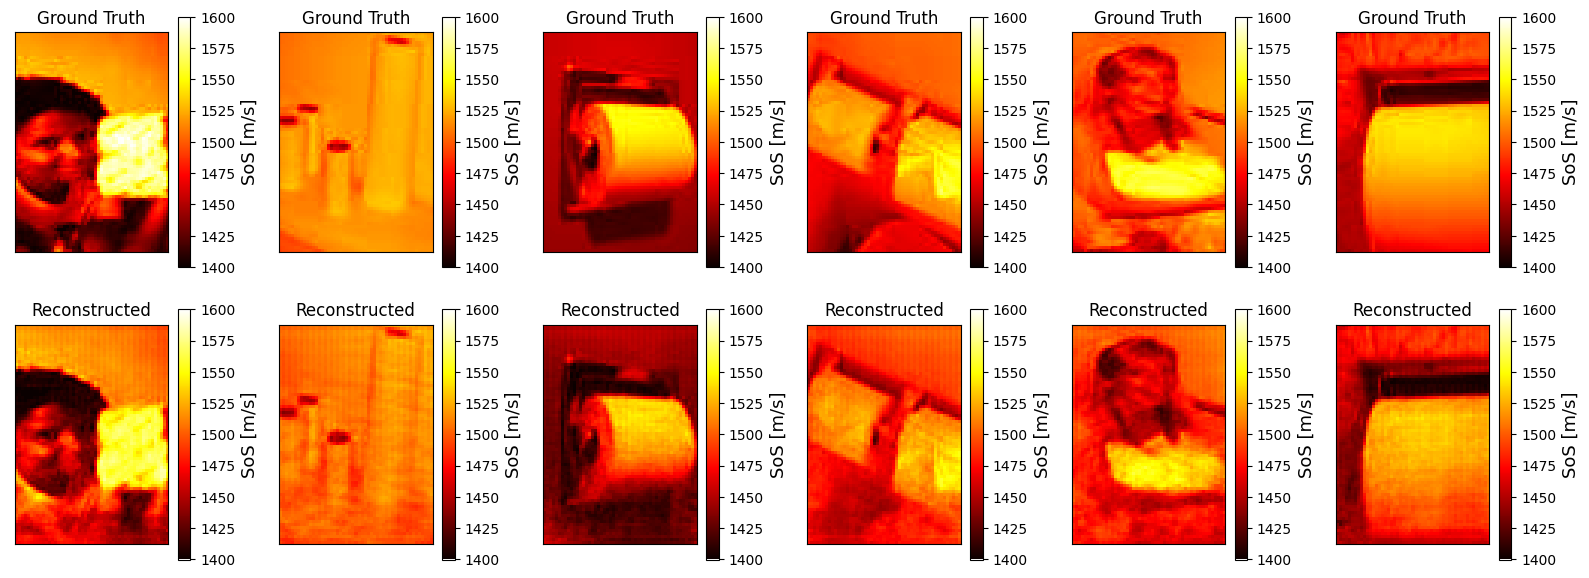

Elapsed time = 87.9494411945343
batch 31001 / 40000
running_loss = 496.5877934130966
batch_loss = 351.0325622558594
queue length = 366
RMSE in testing set is 14.416012
Elapsed time = 85.97220253944397
batch 32001 / 40000
running_loss = 491.8831711144427
batch_loss = 412.4306945800781
queue length = 316
RMSE in testing set is 13.629817
Elapsed time = 85.16241216659546
batch 33001 / 40000
running_loss = 487.2558617653987
batch_loss = 254.70947265625
queue length = 416
RMSE in testing set is 13.475245


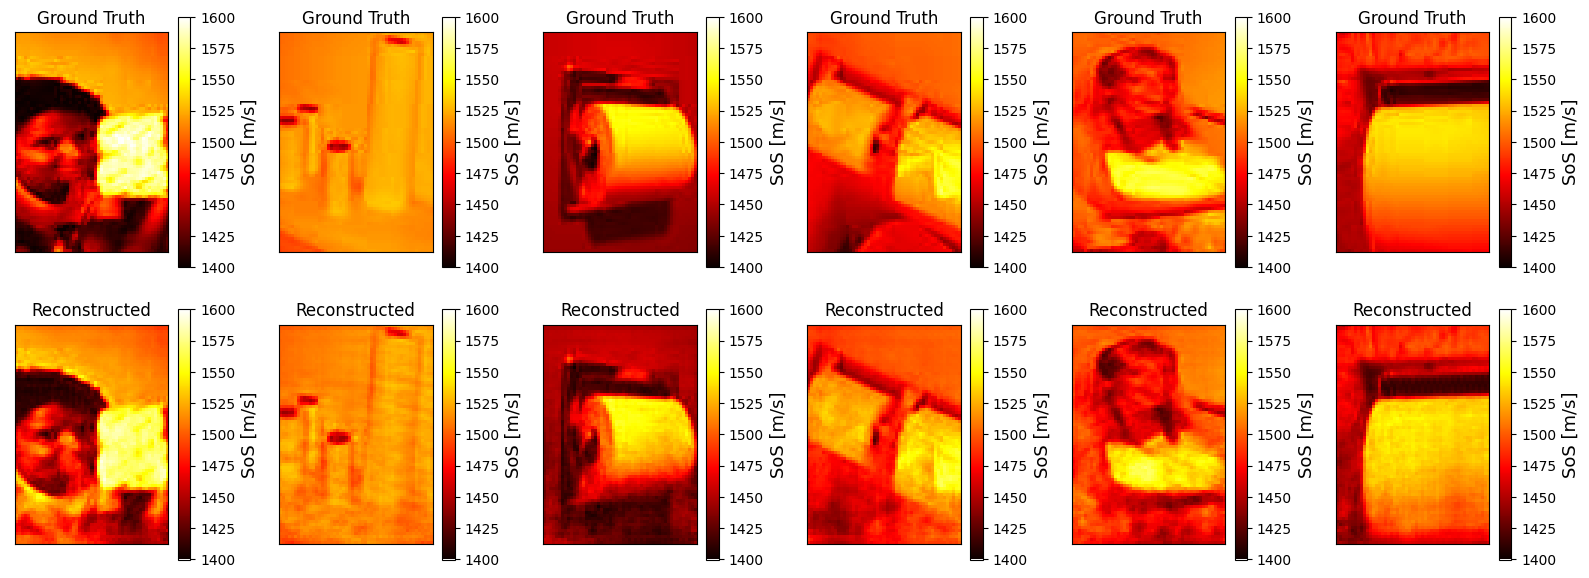

Elapsed time = 86.80738759040833
batch 34001 / 40000
running_loss = 482.96375800202816
batch_loss = 291.3145446777344
queue length = 66
RMSE in testing set is 15.247763
Elapsed time = 88.82594513893127
batch 35001 / 40000
running_loss = 478.7098238363953
batch_loss = 324.82427978515625
queue length = 16
RMSE in testing set is 14.46426
Elapsed time = 89.00184345245361
batch 36001 / 40000
running_loss = 474.6309071175225
batch_loss = 378.92718505859375
queue length = 116
RMSE in testing set is 14.312118


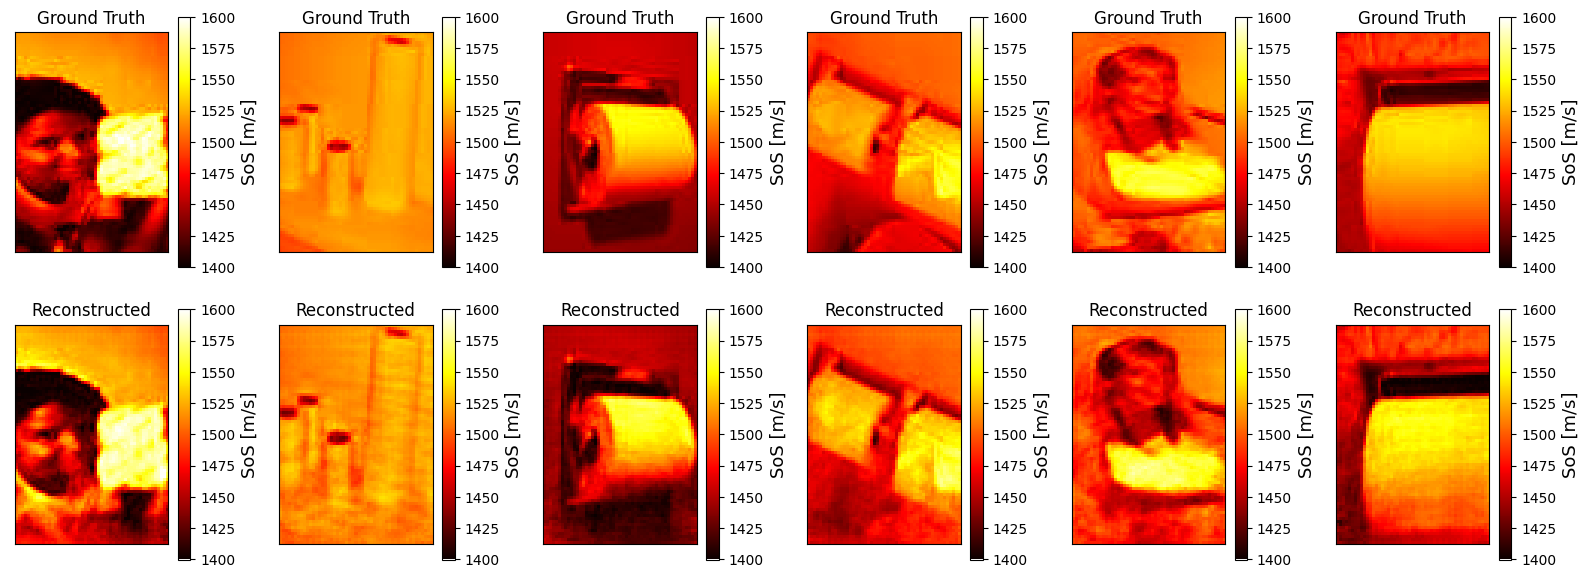

Elapsed time = 82.23791360855103
batch 37001 / 40000
running_loss = 470.8065342250292
batch_loss = 241.35806274414062
queue length = 336
RMSE in testing set is 13.535986
Elapsed time = 81.31963443756104
batch 38001 / 40000
running_loss = 467.05124500524204
batch_loss = 321.159423828125
queue length = 136
RMSE in testing set is 17.030838
Elapsed time = 86.50272226333618
batch 39001 / 40000
running_loss = 463.4625784352305
batch_loss = 277.8002014160156
queue length = 416
RMSE in testing set is 14.323076


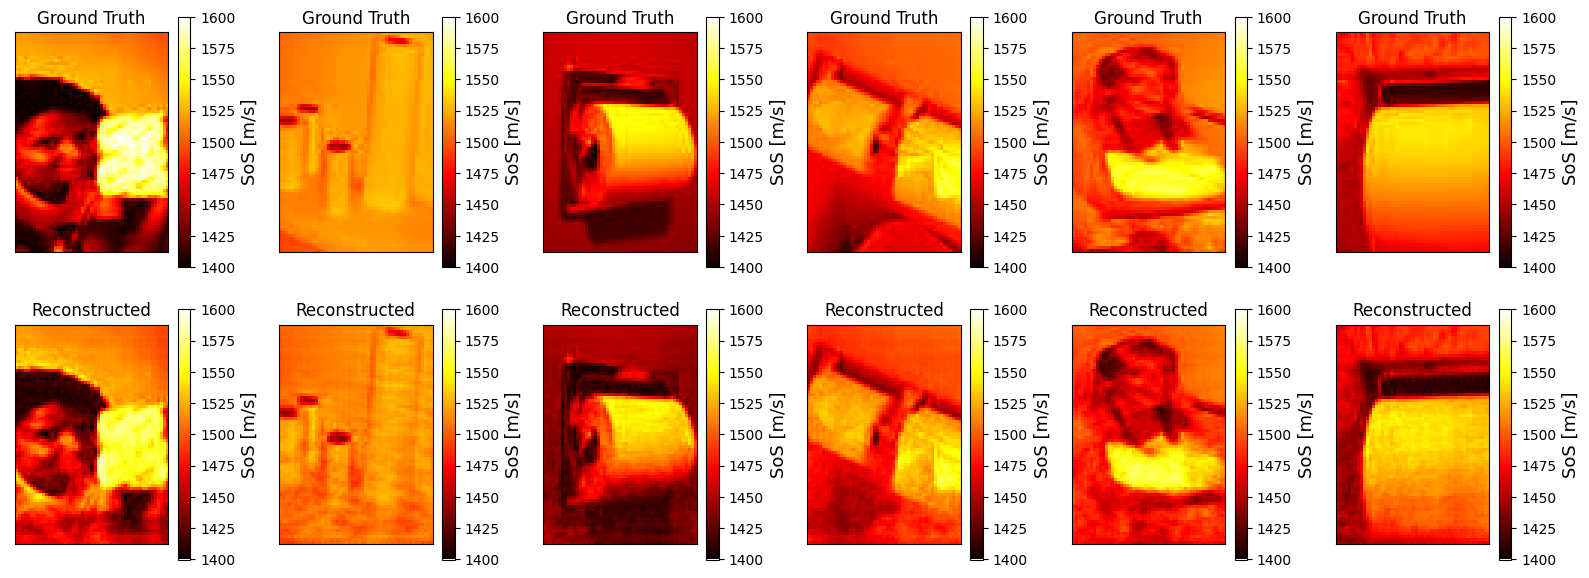

In [ ]:
model = build_net().to(f"cuda:{GPU_BASE}")
model = nn.DataParallel(model, device_ids=GPU_LIST_TO_PARALLEL)
model.train()
set_stateless_batchnorm(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=PARAM_LEARNING_RATE, weight_decay=PARAM_WEIGHTDECAY)

manager = mp.Manager()
shared_queue_time_lag = manager.list()
shared_lock_1, shared_lock_2 = mp.Lock(), mp.Lock()
idx_list_init = list(range(PARAM_NUMBER_OF_TRAINING_DATA))
random.shuffle(idx_list_init)
img_idx_tobe_loaded = manager.list(idx_list_init)


processes = [
    mp.Process(
        target=preparing_training_data,
        args=(
            shared_lock_1,
            shared_lock_2,
            img_idx_tobe_loaded,
            shared_queue_time_lag,
            PARAM_NUMBER_OF_TRAINING_DATA,
            4000,
            data_parent_dir,  # <--- Pass the data dir to the worker
        ),
    )
    for _ in range(3)
]
for p in processes:
    p.start()
    sleep(1)

LEN_TRAINING_DATA = PARAM_NUMBER_OF_TRAINING_DATA
last_time_stamp = time.time()
for epoch_i in range(EPOCH_NUM):
    running_loss = 0.0
    for batch_i in range(LEN_TRAINING_DATA // BATCH_SIZE):
        batch_data_np, batch_label_np = [], []
        for _ in range(BATCH_SIZE):
            while len(shared_queue_time_lag) == 0:
                sleep(1)
            time_lag_np, sos_np = shared_queue_time_lag.pop()
            batch_data_np.append(time_lag_np * PARAM_SCALING_INPUT)
            batch_label_np.append(sos_np)

        batch_data = torch.from_numpy(np.stack(batch_data_np)).to(f"cuda:{GPU_BASE}", dtype=torch.float)
        batch_label = torch.from_numpy(np.stack(batch_label_np)).unsqueeze(1).to(f"cuda:{GPU_BASE}", dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(
            outputs[:, :, :, 19:-19] * PARAM_SCALING_OUTPUT + PARAM_BASE_OUTPUT,
            batch_label[:, :, :, 19:-19],
        )
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_i % 1000 == 1:
            print("Elapsed time =", time.time() - last_time_stamp)
            last_time_stamp = time.time()
            print(f"batch {batch_i} / {LEN_TRAINING_DATA // BATCH_SIZE}")
            print("running_loss =", running_loss / (batch_i + 1))
            print("batch_loss =", loss.item())
            print("queue length =", len(shared_queue_time_lag))

            from datetime import datetime
            current_date = datetime.now().strftime("%Y_%m_%d")
            ckpt_name = (
                f"./pre_trained_model_d{current_date}_parametric_3_input_beamforming_SoS_"
                f"{PARAM_SOS_BEAMFORMING}_output_base_{PARAM_BASE_OUTPUT}_NumberOfTraningData_"
                f"{PARAM_NUMBER_OF_TRAINING_DATA}_learning_rate_{PARAM_LEARNING_RATE}_"
                f"PARAM_WEIGHTDECAY_{PARAM_WEIGHTDECAY}_no_batch_norm.pt"
            )
            torch.save(model.module.state_dict(), ckpt_name)
            model.eval()
            eval_testingdata(model, test_data, test_label, criterion)
            if batch_i % 3000 == 1:
                visualize_test_data()
            model.train()

    print(f"Epoch {epoch_i + 1}/{EPOCH_NUM} finished. "
          f"Average loss: {running_loss / (LEN_TRAINING_DATA / BATCH_SIZE)}")
